# 3a
I chose to make a function that can calculate the qualit of triangulation using the method specified in the notes. At the end of the document I display the results of the implementation in line 7

In [1]:
import numpy as np

def quality_meaure(nodes, triangles, edges):
    """
    Computes the the quality of triangulation, q1, for each element in the mesh given by "triangles" created by "nodes"
    
    inputs:
     - nodes: 2D numpy array with 2 columns representing the x- and y- coordinates of the nodes.
     - triangles: 2D numpy array with 3 columns, the e-th row lists the 3 vertices of the e-th element.
     - edges: 2D numpy array with 2 columns. In each row, two vertices of one edge is listed.
     
    outputs:
     - q1: 1D numpy array that contains the quality of triangulation, q1, for each element in the mesh
    """
    
    # Initialize the output vector
    q1 = np.zeros(len(triangles))
    
    # pre-compute the length of all edges in the mesh and store in vector
    edge_lengths = np.zeros(len(edges))
    for i in range(len(edges)):
        node1 = edges[i, 0]
        node2 = edges[i, 1]
        p1 = np.array(nodes[node1 - 1, :])
        p2 = np.array(nodes[node2 - 1, :])
        edge_lengths[i] = np.linalg.norm(p1 - p2)
    
    # Loop through "triangles" and find the leg lengths that correspond to them 
    for i in range(len(triangles)):
        
        # for the leg specified by nodes given, this is the leg's index in "edge_lengths"
        s1 = np.where(np.all(edges == np.array([triangles[i, 0], triangles[i, 1]]), axis=1))[0] 
        s2 = np.where(np.all(edges == np.array([triangles[i, 0], triangles[i, 2]]), axis=1))[0]
        s3 = np.where(np.all(edges == np.array([triangles[i, 1], triangles[i, 2]]), axis=1))[0]
        
        # specify the lengths of the legs of the element of focus
        a = edge_lengths[s1]
        b = edge_lengths[s2]
        c = edge_lengths[s3]
        s = 0.5*(a + b + c)
        
        # Define the paraeters used for the measure of quality
        dT = 2*np.sqrt(((s - a)*(s - b)*(s - c))/s)
        diamT = max(a, b, c)
        
        q1[i] = (np.sqrt(3)*dT)/diamT
        
    return q1, edge_lengths

In [2]:
import numpy as np

def gaussQuadStd1d(g, noOfIntegPt):
    """Computes the integral ∫ g(ξ) dξ using Gaussian quadrature on [-1,1]"""
    if noOfIntegPt == 2:
        points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
        weights = np.array([1, 1])
    elif noOfIntegPt == 3:
        points = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
        weights = np.array([5/9, 8/9, 5/9])
    else:
        return 0
    
    return sum(w * g(xi) for w, xi in zip(weights, points))

def gaussQuad1d(fn, lowerLimit, upperLimit, noOfIntegPt):
    transform = lambda ξ: (upperLimit - lowerLimit) / 2 * ξ + (upperLimit + lowerLimit) / 2
    g = lambda ξ: fn(transform(ξ)) * (upperLimit - lowerLimit) / 2 

    return gaussQuadStd1d(g, noOfIntegPt)

In [3]:
from scipy.optimize import root_scalar

def midPtCurve(f, fder, x1, x2):
    """
    Find the midpoint along the curve y = f(x) from x1 to x2 in arc length.

    inputs:
    - f: function f(x)
    - fder: derivative f'(x)
    - x1, x2: x-coordinates of curve segment endpoints

    output:
    - (xm, ym): coordinates of the midpoint along the curve
    """

    # Define the arc length integrand
    #def arc_length_integrand(x):
     #   return np.sqrt(1 + (fder(x))**2)
    arc_length_integrand = lambda t: np.sqrt(1 + (fder(t))**2)

    # Compute total arc length (L) from x1 to x2
    L = gaussQuad1d(arc_length_integrand, x1, x2, 2)
    
    # Define the arc length function (l(x)) from x1 to x
    l = lambda x: gaussQuad1d(arc_length_integrand, x1, x, 2)

    # Define m(x) = l(x) - L/2
    m = lambda x: l(x) - L/2

    # Use root-finding to solve m(xm) = 0
    sol = root_scalar(m, bracket=[x1, x2], method='brentq', xtol=1e-6)

    if not sol.converged:
        raise ValueError("Root finding for midpoint did not converge.")

    xm = sol.root
    ym = f(xm)

    return xm, ym

In [4]:
######
# This file contains functions that support regular refinement of a triangulation
#
# Last update: Chung-min Lee March 26, 2025

import numpy as np
!!!!! NOTE THAT YOU NEED TO IMPORT midPtCurve !!!!!

# refine the domain by dividing each triangle to 3 triangles
def refine(nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder):
    '''
        Refine a domain
        nodes,triangles,edges,bdyNode,bdyEdge,curveEdge = refine(nodes, triangles, edges, bdyNode, bdyEdge, 
                                                                    curveEdge, bdyFn, bdyFnder)
        this program refines a triangulation using standard refinement
        input and output:
         - nodes - 2-column array that stores the (x,y)-coordinates of nodes
         - trangles - 3-column array that stores the nodes in each triangle
         - edges - 2-column array that stores the end nodes of edges
         - bdyNode - 1D array that indicates if a node is a boundary node
         - bdyEdge - 1D array that indicates if an edge is a boundary edge
         - curveEdge - 1D array that indicates if an edge is an approximation of a curve
         - bdyFn - a function represents the function that describe the boundary
         0 bdyFnder - the derivative of the boundary function
    '''
    noTri = np.shape(triangles)[0] # no of triangles
    noNode = np.shape(nodes)[0] # no of nodes
    parentNodes = np.array([]).reshape((0,2)) # track where the midpoint is from
    
    # go through triangles to get midpoints
    for k in range(0,noTri):
        node1 = triangles[k,0]
        node2 = triangles[k,1]
        node3 = triangles[k,2]
        
        # check the first edge
        inEdges = (np.sum((edges == node1)+(edges == node2),axis=1)==2) # find where the first edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
            
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x1m, y1m = midPtCurve(bdyFn, bdyFnder, nodes[node1 - 1, 0], nodes[node2 - 1,0])
            else:
                x1m = 0.5*(nodes[node1 - 1, 0] + nodes[node2 - 1, 0])
                y1m = 0.5*(nodes[node1 - 1, 1] + nodes[node2 - 1, 1])
            # endif curveEdge
    
            nodes, edges, bdyNode, bdyEdge, curveEdge = updateTri(x1m, y1m, node1, node2, edgeNo, nodes, edges, bdyNode, bdyEdge, curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt1 = numNode # record the node number of the 1st midpoint
            parentNodes = np.vstack((parentNodes,[node1,node2])) # record the parents that produce this midpoints
        else: # not in existing edges
            # find the node number for the 1st midpoint
            nodeNo4MidPt1 = noNode + np.where(np.sum((parentNodes==node1) + (parentNodes==node2),axis=1)==2)[0][0]+1
        # endif inEdges
        
        # check the second edge
        inEdges = (np.sum((edges==node2)+(edges==node3),axis=1)==2) # find where the second edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
            
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x2m,y2m = midPtCurve(bdyFn,bdyFnder,nodes[node2-1,0],nodes[node3 - 1, 0])
            else:
                x2m = 0.5*(nodes[node2-1,0]+nodes[node3-1,0])
                y2m = 0.5*(nodes[node2-1,1]+nodes[node3-1,1])
            # endif curveEdge
            
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x2m,y2m,node2,node3,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt2 = numNode # record the node number of the 2nd midpoint
            parentNodes = np.vstack((parentNodes,[node2, node3])) # record the parents that produce this midpoints
        else: # not in existing edges
            # find the node number for the 2nd midpoint
            nodeNo4MidPt2 = noNode + np.where(np.sum((parentNodes==node2) + (parentNodes==node3),axis=1)==2)[0][0]+1
        # endif inEdges
        
        # check the third edge
        inEdges = (np.sum((edges==node1)+(edges==node3),axis=1)==2) # find where the third edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
            
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x3m,y3m = midPtCurve(bdyFn,bdyFnder,nodes[node1-1,0],nodes[node3-1,0])
            else:
                x3m = 0.5*(nodes[node1-1,0]+nodes[node3-1,0])
                y3m = 0.5*(nodes[node1-1,1]+nodes[node3-1,1])
            # endif curveEdge
            
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x3m,y3m,node1,node3,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt3 = numNode # record the node number of the 3rd midpoint
            parentNodes = np.vstack((parentNodes,[node1, node3])) # record the parents that produce this midpoints
        else: # not in existing edges
            # find the node number for the 3rd midpoint
            nodeNo4MidPt3 = noNode + np.where(np.sum((parentNodes==node1)+(parentNodes==node3),axis=1)==2)[0][0]+1
        # endif inEdges
    
        # put the 3 new edges in (cnnecting 3 midpoints)
        edges = np.vstack((edges,[[nodeNo4MidPt1, nodeNo4MidPt2],[nodeNo4MidPt2,nodeNo4MidPt3],[nodeNo4MidPt1, nodeNo4MidPt3]]))
        bdyEdge = np.hstack((bdyEdge,[0,0,0]))
        curveEdge = np.hstack((curveEdge,[0,0,0]))
        # replace this triangle in the triangle list by 4 new triangles
        triangles[k,:] = np.array([node1, nodeNo4MidPt1, nodeNo4MidPt3])
        triangles = np.vstack((triangles,[node2, nodeNo4MidPt2, nodeNo4MidPt1]))
        triangles = np.vstack((triangles,[node3, nodeNo4MidPt3, nodeNo4MidPt2]))
        triangles = np.vstack((triangles,[nodeNo4MidPt1, nodeNo4MidPt2,nodeNo4MidPt3]))
    # endfor all triangles
    
    return nodes, triangles, edges, bdyNode, bdyEdge, curveEdge

###################### update triangles and nodes, used in refine
def updateTri(xm, ym, parentNode1, parentNode2, edgeNo, nodes, edges, bdyNode, bdyEdge, curveEdge):
    '''
        The function that updates nodes, edges, bdyNode, bdyEdge, curveEdge when doing refinement
        [nodes,edges,bdyNode,bdyEdge,curveEdge] = updateTri(xm,ym,parentNode1,parentNode2,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
        Chung-min Lee Mar 26, 2025
    '''
    # add the midpoint to nodes
    nodes = np.vstack((nodes, [xm, ym]))
    row = len(nodes[:,1])
    
    # replace the original edge by 2 new edges
    edges[edgeNo,:] = np.array([parentNode1, row])
    edges = np.vstack((edges,[parentNode2, row]))
    
    # if the parent nodes are on a bdyEdge, then this midpoint is a boundary
    # node and both new edges are boundary edges
    if (bdyEdge[edgeNo] == 1):
        bdyNode = np.hstack((bdyNode,[1]))
        bdyEdge = np.hstack((bdyEdge,[1]))
    else:
        bdyNode = np.hstack((bdyNode,[0]))
        bdyEdge = np.hstack((bdyEdge,[0]))
    # endif boundary edge
    # update curveEdge for two new edges
    if (curveEdge[edgeNo] == 1):
        curveEdge = np.hstack((curveEdge,[1]))
    else:
        curveEdge = np.hstack((curveEdge,[0]))
    # endif curveEdge
    
    return nodes, edges, bdyNode, bdyEdge, curveEdge

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_triangulations(nodes1, triangles1, nodes2, triangles2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # First mesh
    axes[0].triplot(nodes1[:, 0], nodes1[:, 1], triangles1 - 1)  # Subtract 1 since triangle indices are 1-based
    axes[0].plot(nodes1[:, 0], nodes1[:, 1], 'o')
    axes[0].set_aspect('equal')
    axes[0].set_title("Original Triangulation")

    # Refined mesh
    axes[1].triplot(nodes2[:, 0], nodes2[:, 1], triangles2 - 1)  # Subtract 1 since triangle indices are 1-based
    axes[1].plot(nodes2[:, 0], nodes2[:, 1], 'o')
    axes[1].set_aspect('equal')
    axes[1].set_title("Twice Refined Triangulation")

    plt.tight_layout()
    plt.show()


# 3a problem set-up

In [6]:
nodes = np.array([[-2, 0], [-1, 0], [0, 1], [1, 0], [2, 0], [1, 1.5], [1, 3], [0, 3], [-1, 1.5]])
triangles = np.array([[1, 2, 9], [2, 3, 9], [3, 4, 6], [4, 5, 6], [6, 7, 8], [3, 6, 8], [3, 8, 9]])
edges= np.array([[1, 2], [1, 9], [2, 3], [2, 9], [3, 4], [3, 6], [3, 8], [3, 9], [4, 5], [4, 6], [5, 6], [6, 7], [6, 8], [7, 8], [8, 9]])
bdyNode = np.ones(9 , dtype=bool)
bdyEdge = np.array([ 1,1,1, 0,1,0, 0,0, 1,0,1, 1,0,1,1], dtype=bool)
curveEdge = np.array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=bool)

# 3a results

In [7]:
q1, edge_lengths = quality_meaure(nodes, triangles, edges)
print(f' q1 = \n{q1}\n')
print(f'min q1(T) = {min(q1)}\n')
print(f'edge lengths = \n {edge_lengths}')

 q1 = 
[0.6698715  0.85909944 0.85909944 0.6698715  0.6698715  0.70396985
 0.70396985]

min q1(T) = 0.66987149950743

edge lengths = 
 [1.         1.80277564 1.41421356 1.5        1.41421356 1.11803399
 2.         1.11803399 1.         1.5        1.80277564 1.5
 1.80277564 1.         1.80277564]


# 3b problem set-up

In [8]:
bdyFn= lambda x: 1 - x**2
bdyFnder = lambda x: -2*x

nodes_rf1, triangles_rf1, edges_rf1, bdyNode_rf1, bdyEdge_rf1, curveEdge_rf1 = refine(nodes.copy(), triangles.copy(), edges.copy(), bdyNode.copy(), bdyEdge.copy(), curveEdge.copy(), bdyFn, bdyFnder)
nodes_rf2, triangles_rf2, edges_rf2, bdyNode_rf2, bdyEdge_rf2, curveEdge_rf2 = refine(nodes_rf1, triangles_rf1, edges_rf1, bdyNode_rf1, bdyEdge_rf1, curveEdge_rf1, bdyFn, bdyFnder)

# 3b results

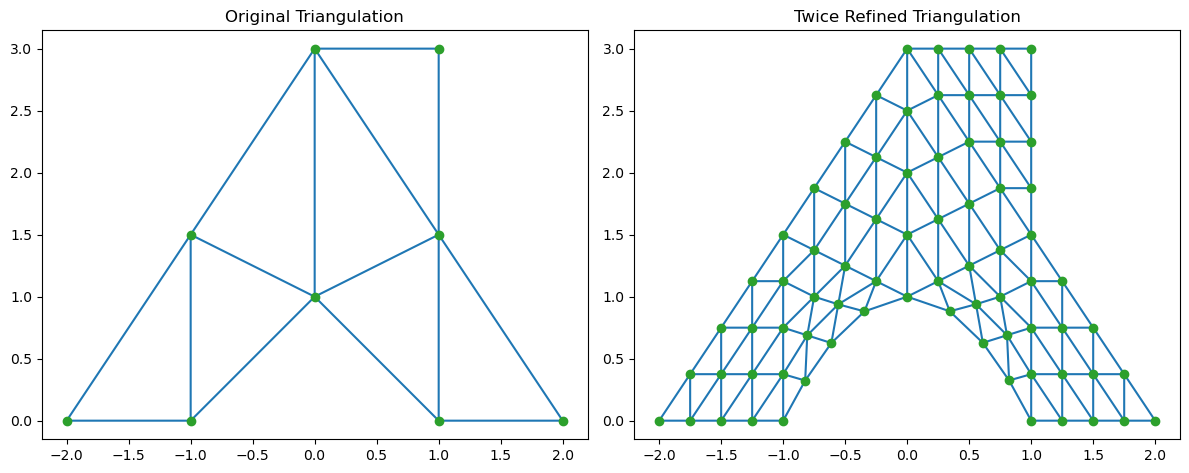

In [9]:
plot_triangulations(nodes, triangles, nodes_rf2, triangles_rf2)